In [ ]:
import os
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
df = pd.DataFrame()
df = pd.read_csv("fraudTest.csv")
df = df[df["is_fraud"]==0].sample(frac=0.20,random_state=42).append(df[df["is_fraud"]==1])
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
50035,50035,2020-07-07 23:36:22,4952583804639909,fraud_Zboncak Ltd,food_dining,59.94,Patricia,Rodriguez,F,386 Randolph Throughway,...,41.2639,-80.8164,75903,Magazine features editor,1957-04-05,131912b15f0f8f7a68df10deba18a254,1373240182,41.559973,-81.185544,0.0
505,505,2020-06-21 15:06:20,4653879239169997,fraud_Kozey-Boehm,shopping_net,4.68,Monica,Tucker,F,302 Christina Islands,...,37.0581,-86.1938,6841,"Therapist, sports",1999-06-06,05f8f3d9bd0d70ed2f59131c35c58be8,1371827180,37.673167,-86.154883,0.0
8096,8096,2020-06-23 14:36:06,4822367783500458,fraud_Parker-Kunde,personal_care,8.20,Christopher,Farrell,M,97070 Anderson Land,...,28.0758,-81.5929,33804,Exercise physiologist,1991-01-01,f2d8e8fecbc6c3938d6b164630658ac6,1371998166,27.100526,-81.250153,0.0
6000,6000,2020-06-22 23:28:37,4756039869079882102,fraud_Berge-Hills,kids_pets,99.41,Francisco,Hernandez,M,980 Smith Gardens,...,33.6547,-97.1583,26120,"Engineer, manufacturing",1954-01-06,4b6590ab98d9856386b2b75453e1d7a9,1371943717,32.855236,-97.404431,0.0
28334,28334,2020-06-30 15:13:11,4450831335606294,fraud_Connelly PLC,food_dining,1.10,Donna,Davis,F,6760 Donovan Lakes,...,34.5906,-95.3800,1760,Occupational psychologist,1972-01-20,c0d24e1ebb919e1b35cc37e92bdcb791,1372605191,33.975861,-95.526924,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23680 entries, 50035 to 116112
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             23680 non-null  int64  
 1   trans_date_trans_time  23680 non-null  object 
 2   cc_num                 23680 non-null  int64  
 3   merchant               23680 non-null  object 
 4   category               23680 non-null  object 
 5   amt                    23680 non-null  float64
 6   first                  23680 non-null  object 
 7   last                   23680 non-null  object 
 8   gender                 23680 non-null  object 
 9   street                 23680 non-null  object 
 10  city                   23680 non-null  object 
 11  state                  23680 non-null  object 
 12  zip                    23680 non-null  int64  
 13  lat                    23680 non-null  float64
 14  long                   23680 non-null  float64
 1

In [ ]:
df["is_fraud"].value_counts()

0.0    23225
1.0      455
Name: is_fraud, dtype: int64

In [ ]:
def bipartile(df_input,graph_type=nx.Graph()):
  df = df_input.copy()
  mapping = {x:node_id for node_id,x in enumerate(set(df["cc_num"].values.tolist() + df["merchant"].values.tolist()))}
  df["from"] = df["cc_num"].apply(lambda x:mapping[x])
  df["to"] = df["merchant"].apply(lambda x:mapping[x])
  df = df[['from','to',"amt","is_fraud"]].groupby(['from','to']).agg({"is_fraud":"sum","amt":"sum"}).reset_index()
  df["is_fraud"]=df["is_fraud"].apply(lambda x:1 if x>0 else 0)
  G = nx.from_edgelist(df[["from","to"]].values,create_using=graph_type)
  nx.set_node_attributes(G,{x:1 for x in df["from"].unique()},"bipartite")
  nx.set_node_attributes(G,{x:2 for x in df["to"].unique()},"bipartite")
  nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["is_fraud"] for idx,x in df[["from","to","is_fraud"]].iterrows()},"label")
  nx.set_edge_attributes(G,{(int(x["from"]),int(x["to"])):x["amt"] for idx,x in df[["from","to","amt"]].iterrows()},"weight")
  return G


In [ ]:
def tripartile(df_input,graph_type=nx.Graph()):
  df = df_input.copy()
  mapping = {x:node_id for node_id,x in enumerate(set(df.index.values.tolist()+df["cc_num"].values.tolist()+df["merchant"].values.tolist()))}
  df["in_node"] = df["cc_num"].apply(lambda x:mapping[x])
  df["out_node"] = df["merchant"].apply(lambda x:mapping[x])
  G = nx.from_edgelist([(x["in_node"],mapping[idx]) for idx, x in df.iterrows()] + [(x["out_node"],mapping[idx]) for idx, x in df.iterrows()],create_using=graph_type)
  nx.set_node_attributes(G,{x["in_node"]:1 for idx,x in df.iterrows()},"bipartite")
  nx.set_node_attributes(G,{x["out_node"]:2 for idx,x in df.iterrows()},"bipartite")
  nx.set_node_attributes(G,{mapping[idx]:3 for idx,x in df.iterrows()},"bipartite")

  nx.set_node_attributes(G,{(x["in_node"],mapping[idx]):x["is_fraud"] for idx,x in df.iterrows()},"label")
  nx.set_node_attributes(G,{(x["out_node"],mapping[idx]):x["is_fraud"] for idx,x in df.iterrows()},"label")

  nx.set_node_attributes(G,{(x["in_node"],mapping[idx]):x["amt"] for idx,x in df.iterrows()},"weight")
  nx.set_node_attributes(G,{(x["out_node"],mapping[idx]):x["amt"] for idx,x in df.iterrows()},"weight")

  return G


In [ ]:
G_bu = bipartile(df,nx.Graph(name='Bipartite Undirected'))
G_bu = bipartile(df,nx.Graph(name='Bipartite Directed'))
G_tu = tripartile(df,nx.Graph(name='Tripartite Undirected'))
G_tu = tripartile(df,nx.Graph(name='Tripartite Directed'))

In [ ]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(G_bu)

True

In [ ]:
print(nx.info(G_bu))

AttributeError: ignored

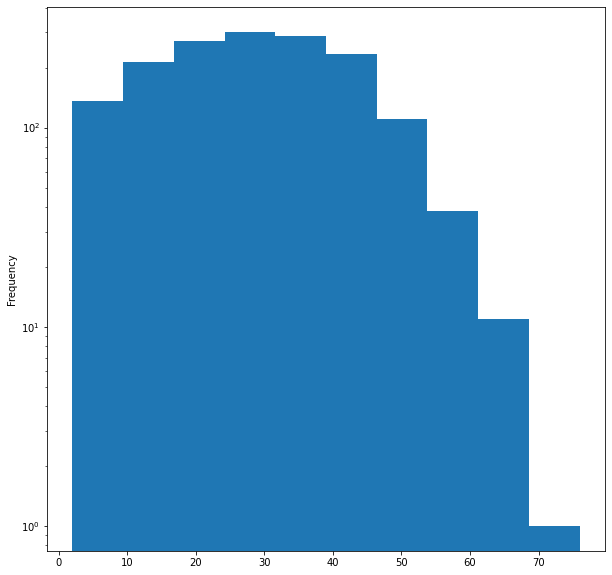

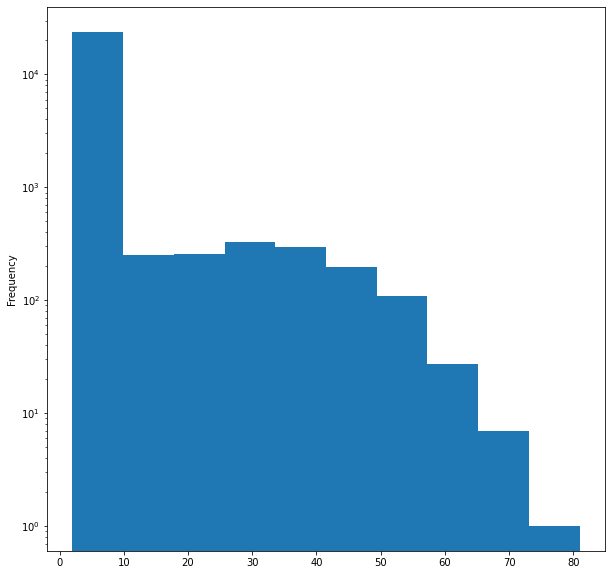

In [ ]:
for G in [G_bu,G_tu]:
  plt.figure(figsize=(10,10))
  degrees = pd.Series(
      {
          k:v for k,v in nx.degree(G)
      }
  )
  degrees.plot.hist()
  plt.yscale("log")

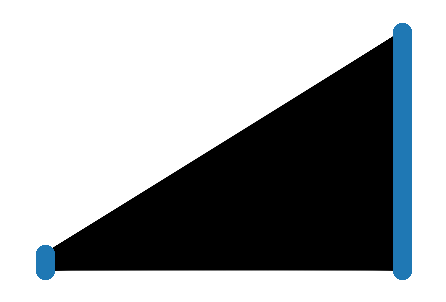

In [ ]:
X, Y = bipartite.sets(G)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(G, pos=pos)
plt.show()

In [ ]:
nx.betweenness_centrality()

IndexError: ignored

In [ ]:
#assortativity
nx.degree_pearson_correlation_coefficient(G_bu)

-0.04142965326793098

In [ ]:
nx.degree_pearson_correlation_coefficient(G_tu)

-0.7702224048671584

In [ ]:
pip install python-louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import community.community_louvain
parts = community_louvain.best_partition(G_bu,random_state=42,weight='weight')
communities = pd.Series(parts)
communities.value_counts().sort_values(ascending=False)

19    114
24    105
16    101
2     100
8      96
9      86
23     80
13     80
11     79
15     78
17     75
0      75
14     73
5      67
4      63
3      61
7      59
6      51
12     48
10     31
20     29
1      23
18     16
22     12
21      3
dtype: int64

<AxesSubplot:ylabel='Frequency'>

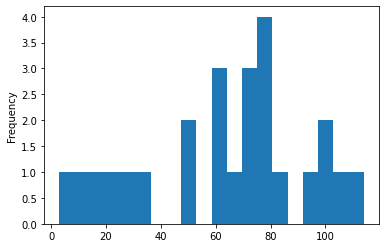

In [ ]:
communities.value_counts().plot.hist(bins=20)

In [ ]:
# ratio of fradulent / benign nodes in communities detected
graphs = []
d = {}
for x in communities.unique():
  tmp = nx.subgraph(G_bu,communities[communities==x].index)
  fraud_edges = sum(nx.get_edge_attributes(tmp,"label").values())
  ratio = 0 if fraud_edges == 0 else (fraud_edges/tmp.number_of_edges()) * 100
  d[x] = ratio
  graphs += [tmp]
pd.Series(d).sort_values(ascending=False)

2     26.178010
15    13.793103
10    12.195122
23    12.142857
4     11.111111
7     10.714286
0      9.848485
19     7.865169
14     6.201550
13     4.705882
5      4.273504
3      3.669725
24     3.463203
11     3.370787
17     3.007519
16     2.164502
8      1.047120
9      0.000000
12     0.000000
6      0.000000
20     0.000000
21     0.000000
1      0.000000
18     0.000000
22     0.000000
dtype: float64

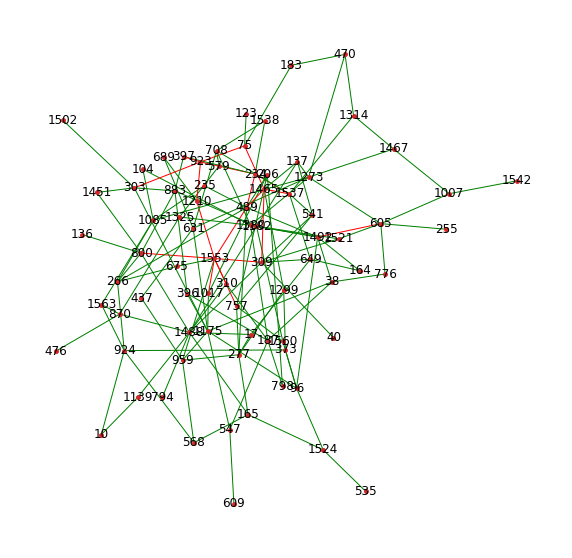

In [ ]:
#fraud edges in each community id
gId = 15
plt.figure(figsize=(10,10))
spring_pos = nx.spring_layout(graphs[gId])
plt.axis("off")
edge_colors = ["r" if x==1 else "g" for x in nx.get_edge_attributes(graphs[gId],'label').values()]
nx.draw_networkx(graphs[gId],pos=spring_pos,node_color="tab:red",edge_color=edge_colors,with_labels=True,node_size=15)

In [ ]:
# Model Building